In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [26]:
%%capture
!pip install mne


# **The DATASET**

In [3]:
from glob import glob
import os
import mne
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import re

In [4]:
ASD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/*.fif')
ADHD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ADHD/*.fif')
test_ASD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/test_ASD/*.fif')
test_ADHD_file_path = glob('/content/gdrive/My Drive/MAIN PROJECT/ICCONS/test_ADHD/*.fif')
print(len(ASD_file_path), len(ADHD_file_path))
print(len(test_ASD_file_path), len(test_ADHD_file_path))

30 26
3 3


In [5]:
def subj_id_finder(file_path):
  pattern = r'(\w+)/(\d+)_(\d+)\.fif'
  match = re.search(pattern, file_path)
  disorder = match.group(1)
  subj_id=int(match.group(2))
  if disorder == 'ADHD':
    subj_id+=16
  return subj_id

In [6]:
raw = mne.io.read_raw_fif(ASD_file_path[0], preload=True)
raw

Opening raw data file /content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/1_1.fif...
Isotrak not found
    Range : 90250 ... 489750 =    361.000 ...  1959.000 secs
Ready.


<ipython-input-6-4292d46f769d>:1: RuntimeWarning: This filename (/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/1_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(ASD_file_path[0], preload=True)


Reading 0 ... 399500  =      0.000 ...  1598.000 secs...


<Raw | 1_1.fif, 21 x 399501 (1598.0 s), ~64.0 MB, data loaded>

In [28]:
from scipy.signal import hann
import matplotlib.pyplot as plt
def sliding_window(file_path, l_freq=1.0, h_freq=30.0, decim_factor=2.5,test=False):

    subj_id = subj_id_finder(file_path)
    raw = mne.io.read_raw_fif(file_path, preload=True)
    raw.filter(l_freq=0.3,h_freq=30)

    data = raw.get_data()

    window_size = 2 * int(raw.info['sfreq'])
    stride = window_size// 2

    windows = []
    for i in range(0, data.shape[1] - window_size + 1, stride):
        window_data = data[:, i:i+window_size]
        # Apply a low-pass anti-aliasing filter to avoid aliasing
        #anti_alias_data = mne.filter.filter_data(window_data, sfreq=raw.info['sfreq'],  l_freq= 40 , h_freq=None,)
        hann_window = hann(window_size, sym=False)
        window_data = window_data*hann_window
        #plt.plot(window_data[20])
        # Decimate the signal
        decimated_data = mne.filter.resample(window_data, down=2.5, npad='auto')
        windows.append(decimated_data)
        if not test:
          group_list.append(subj_id)


    arr = np.array(windows)
    if len(arr)!=0:
      return arr

In [8]:
sample_data = sliding_window(ASD_file_path[11])
sample_data.shape

Opening raw data file /content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/6_1.fif...
Isotrak not found
    Range : 123000 ... 126000 =    492.000 ...   504.000 secs
Ready.
Reading 0 ... 3000  =      0.000 ...    12.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 2751 samples (11.004 s)



<ipython-input-7-119ef3b01311>:6: RuntimeWarning: This filename (/content/gdrive/My Drive/MAIN PROJECT/ICCONS/ASD/6_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished


NameError: ignored

In [29]:
%%capture
group_list=[]
ASD_epochs_arr = [sliding_window(i) for i in ASD_file_path if sliding_window(i) is not None]
ADHD_epochs_arr = [sliding_window(i) for i in ADHD_file_path]
test_ASD_epochs_arr = [sliding_window(i,test=True) for i in test_ASD_file_path]
test_ADHD_epochs_arr = [sliding_window(i,test=True) for i in test_ADHD_file_path]

In [30]:
ASD_epochs_arr[1].shape,len(ASD_epochs_arr)

((1597, 21, 200), 30)

In [31]:
ASD_epochs_labels = [len(i)*[0] for i in ASD_epochs_arr.copy()]
ADHD_epochs_labels = [len(i)*[1] for i in ADHD_epochs_arr.copy()]
test_ASD_epochs_labels = [len(i)*[0] for i in test_ASD_epochs_arr.copy()]
test_ADHD_epochs_labels = [len(i)*[1] for i in test_ADHD_epochs_arr.copy()]
len(ASD_epochs_labels),len(ADHD_epochs_labels)

(30, 26)

In [32]:
data_list = ASD_epochs_arr.copy()+ADHD_epochs_arr.copy()
ADHD_epochs_arr=0
ASD_epochs_arr=0
label_list = ASD_epochs_labels+ADHD_epochs_labels
test_data_list = test_ASD_epochs_arr.copy()+test_ADHD_epochs_arr.copy()
test_ASD_epochs_arr=0
test_ADHD_epochs_arr=0
test_label_list = test_ASD_epochs_labels+test_ADHD_epochs_labels

In [33]:
data_list[11]


array([[[ 2.09160432e-03, -2.14133773e-03,  4.76278543e-03, ...,
          3.66077335e-02,  2.68111582e-02,  7.22818859e-04],
        [ 3.74091178e-03, -3.57280983e-03,  1.16012824e-02, ...,
          8.61345711e-02,  3.92778403e-02,  1.56725911e-02],
        [ 1.94835730e-03, -2.54816661e-03, -1.91581863e-03, ...,
          2.16720304e-02,  5.18584121e-03,  6.42211801e-03],
        ...,
        [ 1.41742244e-05, -1.14540856e-03, -3.22191892e-03, ...,
          1.07336252e-01,  4.37719770e-02,  1.94257357e-02],
        [-4.58622785e-03,  2.69882386e-03, -1.89452754e-02, ...,
         -1.47778268e-02,  6.92708855e-03, -1.06314400e-02],
        [-4.20534072e-03,  2.16609441e-03, -5.94059896e-03, ...,
         -9.56849144e-02, -2.41516679e-02, -2.77188471e-02]],

       [[-1.75951944e-03, -1.97243882e-02, -7.84669910e-02, ...,
          1.03242093e-01,  2.56339949e-02,  2.56020124e-02],
        [-1.79312957e-03, -1.51117450e-02, -6.34362681e-02, ...,
          4.90004629e-02,  3.50854987e

In [34]:
print(len(data_list))
len(group_list),len(label_list)

56


(57898, 56)

In [35]:
train_features = np.vstack(data_list)
test_features = np.vstack(test_data_list)
label_arr = np.hstack(label_list)
test_labels = np.hstack(test_label_list)
group_arr =np.hstack(group_list)

In [36]:
group_arr.shape,train_features.shape,label_arr.shape

((57898,), (36310, 21, 200), (36310,))

In [13]:
group_arr

array([ 1,  1,  1, ..., 31, 31, 31])

In [37]:
test_features = np.moveaxis(test_features,1,2)
test_features.shape
train_features = np.moveaxis(train_features,1,2)
train_features.shape

(36310, 200, 21)

In [38]:
data_list=0
test_data_list=0
label_list=0
test_label_list=0

In [39]:
label_arr

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
train_labels = label_arr.copy()

In [41]:
train_labels.shape

(36310,)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler =  StandardScaler()
# test_features=scaler.fit_transform(test_data.reshape(-1,\
#                     test_data.shape[-1])).reshape(test_data.shape)


## **Train-Test split**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
scaler =  StandardScaler()
gkf=GroupKFold(n_splits=5)


In [ ]:
train_index, val_index = gkf.split(data_arr, label_arr, groups=group_arr)
val_index

NameError: ignored

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(data_arr, label_arr, test_size=0.2,
                                                                        random_state=42, stratify=label_arr)

In [ ]:
# Use GroupKFold to split the data into training and validation sets
co=0
for train_index, val_index in gkf.split(data_arr, label_arr, groups=group_arr):
    # Use the train_index and val_index to create the training and validation sets
    train_data = data_arr[train_index]
    train_labels = label_arr[train_index]
    test_data = data_arr[val_index]
    test_labels = label_arr[val_index]
    print(val_index)
    co+=1
    print(co)

ValueError: ignored

In [ ]:
train_data = data_arr[train_index[0]]
train_labels = label_arr[train_index[0]]
val_data = data_arr[val_index[0]]
val_labels = label_arr[val_index[0]]

NameError: ignored

In [ ]:
train_data = np.moveaxis(train_data,1,2)
val_data  = np.moveaxis(val_data,1,2)

In [ ]:
val_data.shape

(3598, 1000, 21)

In [ ]:
val_labels

array([0, 0, 0, ..., 1, 1, 1])

In [43]:

train_features=scaler.fit_transform(train_features.reshape(-1,\
                    train_features.shape[-1])).reshape(train_features.shape)
#val_features=scaler.transform(val_data.reshape(-1,\
#                   val_data.shape[-1])).reshape(val_data.shape)
test_features=scaler.fit_transform(test_features.reshape(-1,\
                    test_features.shape[-1])).reshape(test_features.shape)

In [ ]:
train_data=[]
test_data=[]

# **CNN Model_1**

In [44]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D,ReLU,MaxPooling1D,InputLayer,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
import keras.backend as K
K.clear_session()

In [51]:
def cnnmodel():
  clear_session()
  model=Sequential()
  model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(700,21)))#1
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))#2
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))#4
  model.add(Dropout(0.5))
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))#6
  model.add(Dropout(0.5))
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))#8
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
  model.add(LeakyReLU())
  model.add(GlobalAveragePooling1D())#10
  model.add(Dense(1,activation='sigmoid'))#11

  model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model
# def cnnmodel():
#   clear_session()
#   model=Sequential()
#   model.add(Conv1D(filters=10,kernel_size=5,strides=1,input_shape=(200,21)))#1
#   model.add(BatchNormalization())
#   model.add(LeakyReLU())
#   model.add(MaxPool1D(pool_size=2,strides=2))#2
#   model.add(Conv1D(filters=20,kernel_size=3,strides=1))#3
#   model.add(LeakyReLU())
#   model.add(MaxPool1D(pool_size=2,strides=2))#4
#   model.add(Dropout(0.5))
#   model.add(Conv1D(filters=30,kernel_size=3,strides=1))#5
#   model.add(LeakyReLU())
#   model.add(AveragePooling1D(pool_size=2,strides=2))#6
#   model.add(Dropout(0.5))
#   model.add(Conv1D(filters=40,kernel_size=3,strides=1))#7
#   model.add(ReLU())
#   model.add(AveragePooling1D(pool_size=2,strides=2))#8
#   model.add(Conv1D(filters=50,kernel_size=3,strides=1))#9
#   model.add(ReLU())
#   model.add(GlobalAveragePooling1D())#10
#   model.add(Dense(64,activation='relu'))#11
#   model.add(Dropout(0.5))
#   model.add(Dense(1,activation='sigmoid'))#12

#   model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
#   return model
model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 196, 10)           1060      
                                                                 
 batch_normalization (BatchN  (None, 196, 10)          40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 196, 10)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 10)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 20)            620       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 20)            0

In [78]:
history = model.fit(train_features,train_labels,epochs=40,batch_size=16,validation_data=(test_features,test_labels))

Epoch 1/40
2270/2270 [==============================] - 52s 17ms/step - loss: 0.3695 - accuracy: 0.8338 - val_loss: 1.0583 - val_accuracy: 0.5322
Epoch 2/40
2270/2270 [==============================] - 37s 16ms/step - loss: 0.2620 - accuracy: 0.8917 - val_loss: 1.1887 - val_accuracy: 0.5501
Epoch 3/40
2270/2270 [==============================] - 36s 16ms/step - loss: 0.2193 - accuracy: 0.9106 - val_loss: 1.2451 - val_accuracy: 0.5354
Epoch 4/40
2270/2270 [==============================] - 37s 17ms/step - loss: 0.1912 - accuracy: 0.9225 - val_loss: 1.2473 - val_accuracy: 0.5498
Epoch 5/40
2270/2270 [==============================] - 39s 17ms/step - loss: 0.1624 - accuracy: 0.9348 - val_loss: 1.4463 - val_accuracy: 0.5468
Epoch 6/40
2270/2270 [==============================] - 36s 16ms/step - loss: 0.1408 - accuracy: 0.9451 - val_loss: 1.2801 - val_accuracy: 0.5534
Epoch 7/40
2270/2270 [==============================] - 38s 17ms/step - loss: 0.1267 - accuracy: 0.9499 - val_loss: 1.5463 -

In [1]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **ChroNet**

In [71]:
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model

In [72]:
def block(input):
  conv1 = Conv1D(filters=32,kernel_size=2,strides=2,activation='relu',padding='causal')(input)
  conv2 = Conv1D(filters=32,kernel_size=4,strides=2,activation='relu',padding='causal')(input)
  conv3 = Conv1D(filters=32,kernel_size=8,strides=2,activation='relu',padding='causal')(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

In [73]:
input = Input(shape=(200, 21))
block1 = block(input)
block1.shape

TensorShape([None, 100, 96])

In [74]:
block2 = block(block1)
block3 = block(block2)
block3.shape

TensorShape([None, 25, 96])

In [75]:
gru1 = GRU(units=32,return_sequences=True)(block3)
gru2 = GRU(units=32,return_sequences=True)(gru1)
gru_out = concatenate([gru1,gru2],axis=2)

gru3 = GRU(units=32,return_sequences=True)(gru_out)
gru_out = concatenate([gru1,gru2,gru3],axis=2)
gru_out.shape

TensorShape([None, 25, 96])

In [76]:
gru4 = GRU(units=32)(gru_out)
out2 = Dense(16,activation='relu')(gru4)
out = Dense(1,activation='sigmoid')(out2)

In [77]:
model = Model(inputs=input,outputs=out)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
val_accs = []
his_Tacc=[]
his_Vacc=[]
his_Tloss=[]
his_Vloss=[]
for train_index, val_index in gkf.split(train_features, train_labels, groups=group_arr):
    # Use the train_index and val_index to create the training and validation sets
    train_data = train_features[train_index]

    train_label = train_labels[train_index]
    test_data = train_features[val_index]
    test_label = train_labels[val_index]

    history = model.fit(train_data,train_label,epochs=10,batch_size=32,validation_data=(test_data,test_label))

    his_Tloss.append(history.history['loss'])
    his_Vloss.append(history.history['val_loss'])
    his_Tacc.append(history.history['accuracy'])
    his_Vacc.append(history.history['val_accuracy'])


    val_accs.append(history.history['val_accuracy'][-1])

print('Average validation accuracy:', sum(val_accs) / len(val_accs))

ValueError: ignored

# **v3**

In [55]:
model = Sequential()
model.add(InputLayer(input_shape=(200, 21)))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
#history = model.fit(train_features,train_labels,epochs=50,batch_size=32,validation_data=(test_features,test_labels))

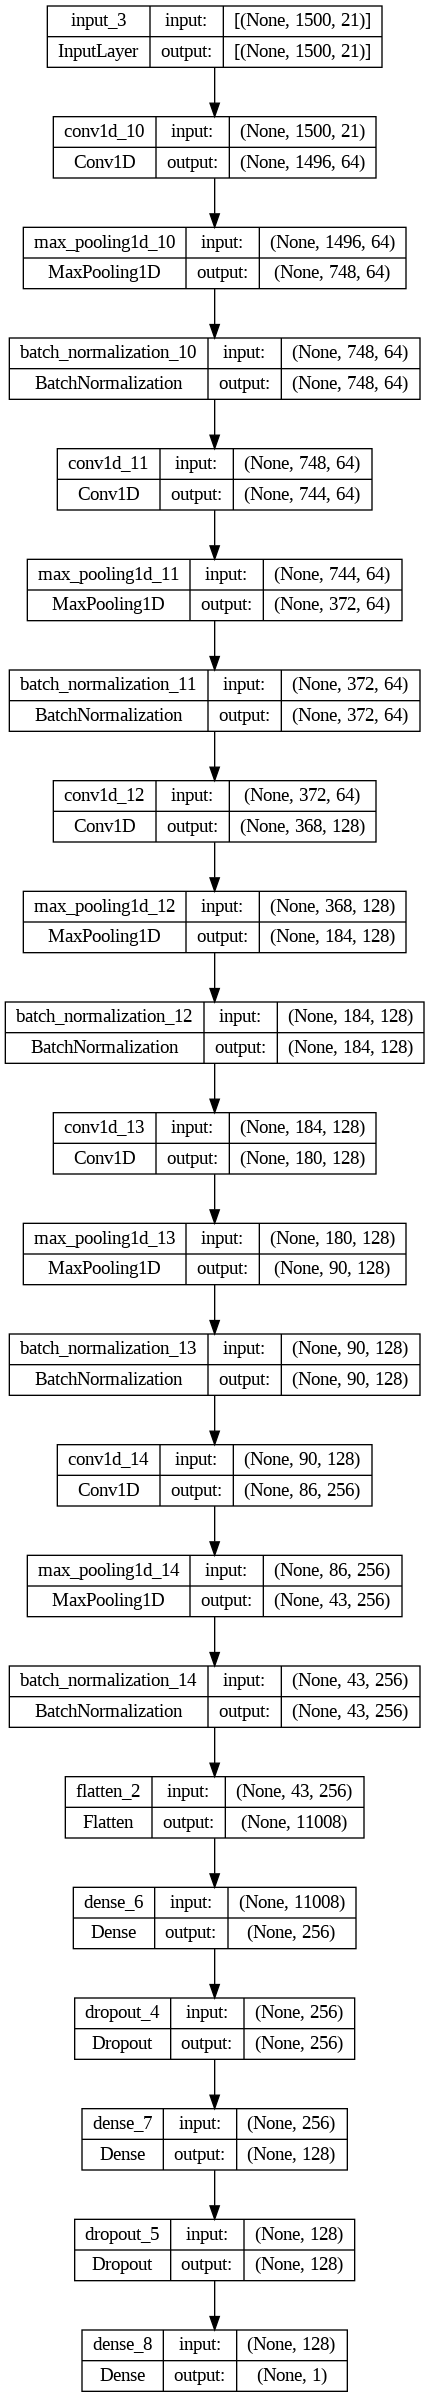

In [ ]:
plot_model(model, to_file="my_model.png", show_shapes=True)

In [27]:
val_accs = []
his_Tacc=[]
his_Vacc=[]
his_Tloss=[]
his_Vloss=[]
for train_index, val_index in gkf.split(train_features, train_labels, groups=group_arr):
    # Use the train_index and val_index to create the training and validation sets
    train_data = train_features[train_index]

    train_label = train_labels[train_index]
    #test_data = train_features[val_index]
    #test_label = train_labels[val_index]

    history = model.fit(train_data,train_label,epochs=100,batch_size=128,validation_data=(test_features,test_labels))

    his_Tloss.append(history.history['loss'])
    his_Vloss.append(history.history['val_loss'])
    his_Tacc.append(history.history['accuracy'])
    his_Vacc.append(history.history['val_accuracy'])


    val_accs.append(history.history['val_accuracy'][-1])

print('Average validation accuracy:', sum(val_accs) / len(val_accs))


ValueError: ignored

In [59]:
history = model.fit(train_features,train_labels,epochs=100,batch_size=64,validation_data=(test_features,test_labels))


Epoch 1/100
568/568 [==============================] - 9s 15ms/step - loss: 0.0510 - accuracy: 0.9819 - val_loss: 1.7287 - val_accuracy: 0.6438
Epoch 2/100
568/568 [==============================] - 7s 12ms/step - loss: 0.0386 - accuracy: 0.9868 - val_loss: 1.9779 - val_accuracy: 0.6415
Epoch 3/100
568/568 [==============================] - 7s 13ms/step - loss: 0.0389 - accuracy: 0.9868 - val_loss: 1.6723 - val_accuracy: 0.6494
Epoch 4/100
568/568 [==============================] - 7s 12ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 2.3411 - val_accuracy: 0.6176
Epoch 5/100
568/568 [==============================] - 7s 12ms/step - loss: 0.0314 - accuracy: 0.9889 - val_loss: 3.1809 - val_accuracy: 0.6092
Epoch 6/100
568/568 [==============================] - 7s 13ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 1.9614 - val_accuracy: 0.6640
Epoch 7/100
568/568 [==============================] - 7s 12ms/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 2.1495 - val_accuracy:

In [ ]:
import itertools
his_Tacc = sum(his_Tacc, [])
his_Vacc = sum(his_Vacc, [])
his_Tloss = sum(his_Tloss, [])
his_Vloss = sum(his_Vloss, [])


In [ ]:
plt.plot(his_Tacc[:], label='Training Accuracy')
plt.plot(his_Vacc[:], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

420/420 [==============================] - 3s 6ms/step - loss: 1.2209 - accuracy: 0.6292
Test accuracy: 0.6292461156845093


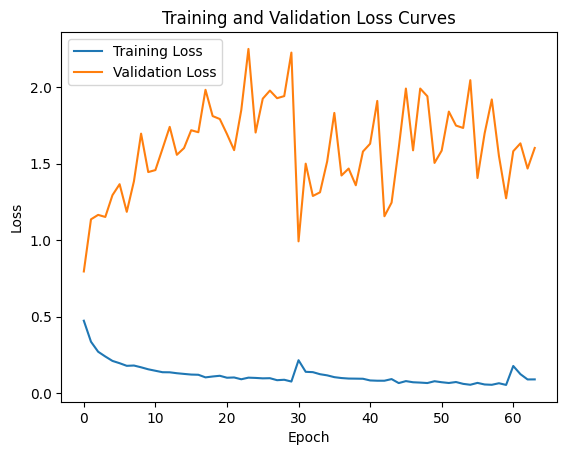

In [ ]:
import matplotlib.pyplot as plt
plt.plot(his_Tloss[:64], label='Training Loss')
plt.plot(his_Vloss[:64], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

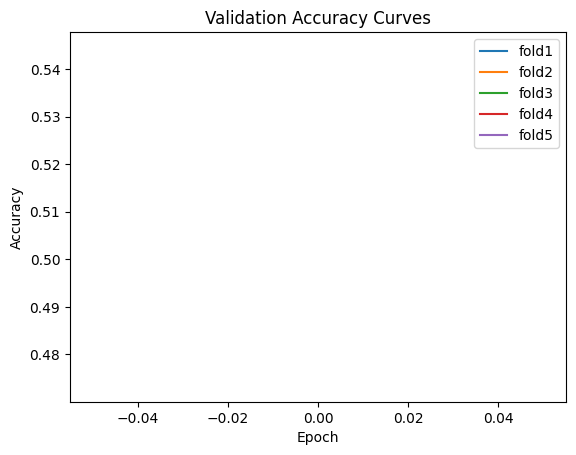

In [ ]:
plt.plot(his_Vacc[0], label='fold1')
plt.plot(his_Vacc[1], label='fold2')
plt.plot(his_Vacc[2], label='fold3')
plt.plot(his_Vacc[3], label='fold4')
plt.plot(his_Vacc[4], label='fold5')
plt.title('Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

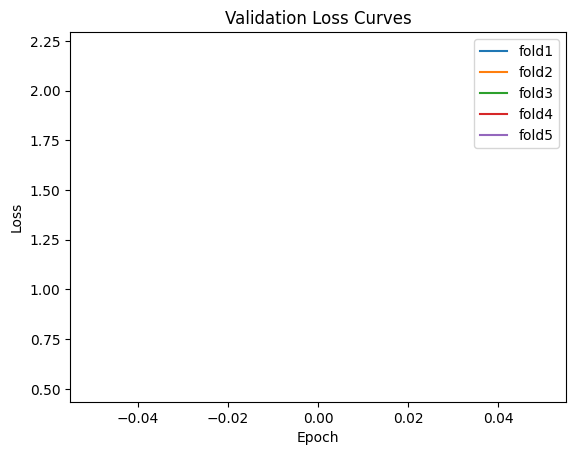

In [ ]:
plt.plot(his_Vloss[0], label='fold1')
plt.plot(his_Vloss[1], label='fold2')
plt.plot(his_Vloss[2], label='fold3')
plt.plot(his_Vloss[3], label='fold4')
plt.plot(his_Vacc[4], label='fold5')
plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

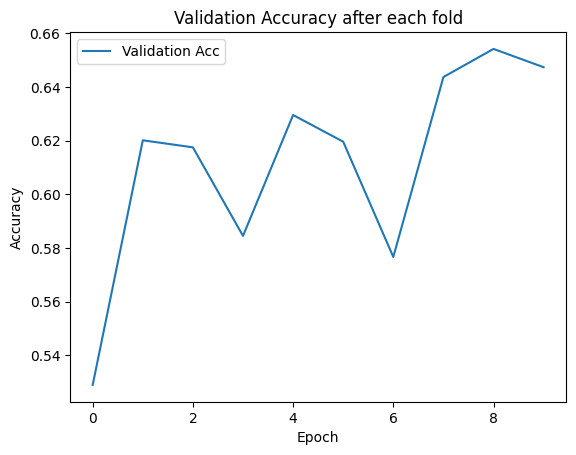

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_accs, label='Validation Acc')
plt.title('Validation Accuracy after each fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model4.h5")

# **V4**

In [63]:
from keras import regularizers
model = Sequential()
model.add(InputLayer(input_shape=(200, 21)))

model.add(Conv1D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])